# Project Milestone 5
Sadie Harper

DSC540-T302 Data Preparation (2217-1)

8/14/2021

In [1]:
# Import libaries
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import json
from pandas.io.json import json_normalize
import requests

C:\tools\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Load in data source 1 (sqlite database)
Bring in data and prepare it base on findings from previous weeks.

In [2]:
# Connect to sqlite database downloaded from Kaggle - https://www.kaggle.com/sashchernuh/european-football
con = sqlite3.connect('database.sqlite')

In [3]:
# Check all tables in database
def sql_fetch(con):

    cursorObj = con.cursor()

    cursorObj.execute('select name from sqlite_master where type= "table"')

    print(cursorObj.fetchall())

In [4]:
sql_fetch(con)

[('betfront',), ('football_data',)]


In [5]:
# Select football data and create a dataframe
cursor = con.execute('select * from football_data')
rows = cursor.fetchall()
fb = pd.DataFrame(rows, columns = [x[0] for x in cursor.description])
fb.head()

,Season,Datetime,Div,Country,League,Referee,HomeTeam,AwayTeam,FTHG,FTAG,...,VCCD,VCCH,VCD,VCH,WHA,WHCA,WHCD,WHCH,WHD,WHH
0,2021,2021-05-31 23:00:00,ARG,Argentina,Primera Division,None,Independiente,Colon Santa FE,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,2021-05-31 19:00:00,ARG,Argentina,Primera Division,None,Racing Club,Boca Juniors,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,2021-05-31 02:30:00,USA,USA,MLS,None,Seattle Sounders,Austin FC,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020/2021,2021-05-31 02:15:00,MEX,Mexico,Liga MX,None,Cruz Azul,Santos Laguna,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021,2021-05-31 00:30:00,BRA,Brazil,Serie A,None,Internacional,Sport Recife,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Select bets data and create a dataframe
cursor2 = con.execute('select * from betfront')
rows2 = cursor2.fetchall()
bets = pd.DataFrame(rows2, columns = [x[0] for x in cursor2.description])
bets.head()

,YEAR,DATETIME,COUNTRY,COMPETION,MATCH,HOME_OPENING,DRAW_OPENING,AWAY_OPENING,HOME_CLOSING,DRAW_CLOSING,AWAY_CLOSING,HT,FT,TOTAL_FT,HTG1,HTG2,FTG1,FTG2
0,2009,2009-02-11 22:30:00,world,world-cup-2010,Malta - Albania,6.89,3.91,1.59,6.70,3.87,1.59,0:0,0:0,0,0.0,0.0,0,0
1,2009,2009-02-11 23:30:00,world,world-cup-2010,San Marino - Northern Ireland,20.52,8.56,1.16,20.52,8.56,1.16,0:2,0:3,3,0.0,2.0,0,3
2,2009,2009-02-11 23:45:00,world,world-cup-2010,Ireland - Georgia,1.37,4.80,11.04,1.37,4.80,11.04,0:1,2:1,3,0.0,1.0,2,1
3,2009,2009-02-12 04:15:00,world,world-cup-2010,USA - Mexico,1.84,3.37,5.08,1.98,3.25,4.61,1:0,2:0,2,1.0,0.0,2,0
4,2009,2009-02-12 06:30:00,world,world-cup-2010,Costa Rica - Honduras,1.93,3.65,4.43,1.89,3.58,4.50,0:0,2:0,2,0.0,0.0,2,0


In [7]:
# drop red card outlier games
print('Old size: {}'.format(fb.shape))
fb = fb[(fb['AR'] != 9.0) & (fb['HR'] != 9.0)]
print('Removed red card outliers size: {}'.format(fb.shape))

Old size: (190673, 172)
Removed red card outliers size: (190671, 172)


In [8]:
# Check values of country from bets dataframe
bets.COUNTRY.unique()

array(['world', 'ireland', 'russia', 'norway', 'usa', 'sweden', 'finland',
       'brazil', 'europe', 'switzerland', 'austria', 'denmark',
       'czech-republic', 'poland', 'belgium', 'netherlands', 'australia',
       'turkey', 'germany', 'england', 'france', 'portugal', 'scotland',
       'argentina', 'greece', 'italy', 'spain', 'mexico', 'chile',
       'japan', 'croatia', 'hungary', 'israel'], dtype=object)

In [9]:
# Fix casing of country so that the first letter is capitalized 
bets['COUNTRY'] = bets['COUNTRY'].map(lambda x: x[0].capitalize() + x[1:])
bets.COUNTRY.unique()

array(['World', 'Ireland', 'Russia', 'Norway', 'Usa', 'Sweden', 'Finland',
       'Brazil', 'Europe', 'Switzerland', 'Austria', 'Denmark',
       'Czech-republic', 'Poland', 'Belgium', 'Netherlands', 'Australia',
       'Turkey', 'Germany', 'England', 'France', 'Portugal', 'Scotland',
       'Argentina', 'Greece', 'Italy', 'Spain', 'Mexico', 'Chile',
       'Japan', 'Croatia', 'Hungary', 'Israel'], dtype=object)

In [10]:
# Check data types of columns in bets data
bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37853 entries, 0 to 37852
Data columns (total 18 columns):
YEAR            37853 non-null int64
DATETIME        37853 non-null object
COUNTRY         37853 non-null object
COMPETION       37853 non-null object
MATCH           37853 non-null object
HOME_OPENING    37853 non-null float64
DRAW_OPENING    37853 non-null float64
AWAY_OPENING    37853 non-null float64
HOME_CLOSING    37853 non-null float64
DRAW_CLOSING    37853 non-null float64
AWAY_CLOSING    37853 non-null float64
HT              37831 non-null object
FT              37853 non-null object
TOTAL_FT        37853 non-null int64
HTG1            37831 non-null float64
HTG2            37831 non-null float64
FTG1            37853 non-null int64
FTG2            37853 non-null int64
dtypes: float64(8), int64(4), object(6)
memory usage: 5.2+ MB


In [11]:
# Change date to be datetime object
bets['DATETIME'] = pd.to_datetime(bets['DATETIME'], format='%Y-%m-%d', errors='ignore')
bets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37853 entries, 0 to 37852
Data columns (total 18 columns):
YEAR            37853 non-null int64
DATETIME        37853 non-null datetime64[ns]
COUNTRY         37853 non-null object
COMPETION       37853 non-null object
MATCH           37853 non-null object
HOME_OPENING    37853 non-null float64
DRAW_OPENING    37853 non-null float64
AWAY_OPENING    37853 non-null float64
HOME_CLOSING    37853 non-null float64
DRAW_CLOSING    37853 non-null float64
AWAY_CLOSING    37853 non-null float64
HT              37831 non-null object
FT              37853 non-null object
TOTAL_FT        37853 non-null int64
HTG1            37831 non-null float64
HTG2            37831 non-null float64
FTG1            37853 non-null int64
FTG2            37853 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(4), object(5)
memory usage: 5.2+ MB


In [12]:
# Check data type of Datetime from football data
fb.dtypes

Season       object
Datetime     object
Div          object
Country      object
League       object
Referee      object
HomeTeam     object
AwayTeam     object
FTHG          int64
FTAG          int64
FTR          object
HTHG          int64
HTAG          int64
HTR          object
PSH         float64
PSD         float64
PSA         float64
B365H       float64
B365D       float64
B365A       float64
LBH         float64
LBD         float64
LBA         float64
BWH         float64
BWD         float64
BWA         float64
ABP         float64
AC          float64
AF          float64
AFKC        float64
             ...   
PD          float64
PH          float64
PSCA        float64
PSCD        float64
PSCH         object
SBA         float64
SBD         float64
SBH         float64
SJA         float64
SJD         float64
SJH         float64
SOA         float64
SOD         float64
SOH         float64
SYA         float64
SYD         float64
SYH         float64
Time         object
VCA         float64


In [13]:
# Change date to be datetime object
fb['Datetime'] = pd.to_datetime(fb['Datetime'], format='%Y-%m-%d', errors='ignore')
fb.dtypes

Season              object
Datetime    datetime64[ns]
Div                 object
Country             object
League              object
Referee             object
HomeTeam            object
AwayTeam            object
FTHG                 int64
FTAG                 int64
FTR                 object
HTHG                 int64
HTAG                 int64
HTR                 object
PSH                float64
PSD                float64
PSA                float64
B365H              float64
B365D              float64
B365A              float64
LBH                float64
LBD                float64
LBA                float64
BWH                float64
BWD                float64
BWA                float64
ABP                float64
AC                 float64
AF                 float64
AFKC               float64
                 ...      
PD                 float64
PH                 float64
PSCA               float64
PSCD               float64
PSCH                object
SBA                float64
S

In [14]:
# Make team name columns
new = bets["MATCH"].str.split("-", n = 1, expand = True)
bets["team_1"]= new[0]
bets['team_1'] = bets['team_1'].str.strip()

bets["team_2"]= new[1]
bets['team_2'] = bets['team_2'].str.strip()

In [15]:
# teams for filtering
teams = ['Leicester', 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester United']

In [16]:
# Check starting size
bets.shape

(37853, 20)

In [17]:
# Filter for first team in list
boolean_series = bets.team_1.isin(teams)
bets_team1 = bets[boolean_series]
bets_team1.shape

(424, 20)

In [18]:
# Filter for second team in list
boolean_series = bets.team_2.isin(teams)
bets_team2 = bets[boolean_series]
bets_team2.shape

(427, 20)

In [19]:
# Concat final table together
bet_info = pd.concat([bets_team1, bets_team2])
bet_info.shape

(851, 20)

In [20]:
# Replace values so team name is fully spelled out for Man U
fb['HomeTeam'] = fb['HomeTeam'].replace('Man United', 'Manchester United')
fb['AwayTeam'] = fb['AwayTeam'].replace('Man United', 'Manchester United')

In [21]:
# Check starting shape
fb.shape

(190671, 172)

In [22]:
# Filter for first team in list
boolean_series = fb.HomeTeam.isin(teams)
fb_home = fb[boolean_series]
fb_home.shape

(2008, 172)

In [23]:
# Filter for first team in list
boolean_series = fb.AwayTeam.isin(teams)
fb_away = fb[boolean_series]
fb_away.shape

(2011, 172)

In [24]:
# Concat final table together
fb_stats = pd.concat([fb_home, fb_away])
fb_stats.shape

(4019, 172)

In [25]:
# Make a key column
bet_info['yr_mo'] = bet_info['DATETIME'].astype(str)
bet_info['yr_mo'] = bet_info['yr_mo'].str[:7]
cols = ['yr_mo', 'MATCH', ]
bet_info['key'] = bet_info[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
bet_info.head()

,YEAR,DATETIME,COUNTRY,COMPETION,MATCH,HOME_OPENING,DRAW_OPENING,AWAY_OPENING,HOME_CLOSING,DRAW_CLOSING,...,FT,TOTAL_FT,HTG1,HTG2,FTG1,FTG2,team_1,team_2,yr_mo,key
1466,2009,2009-08-08 19:00:00,England,championship-2009-2010,Leicester - Swansea,2.30,3.28,3.57,2.26,3.28,...,2:1,3,0.0,1.0,2,1,Leicester,Swansea,2009-08,2009-08 Leicester - Swansea
1608,2009,2009-08-15 15:45:00,England,premier-league-2009-2010,Chelsea - Hull City,1.21,8.40,21.00,1.17,8.80,...,2:1,3,1.0,1.0,2,1,Chelsea,Hull City,2009-08,2009-08 Chelsea - Hull City
1699,2009,2009-08-16 16:30:00,England,premier-league-2009-2010,Manchester United - Birmingham,1.27,6.01,18.00,1.23,5.70,...,1:0,1,1.0,0.0,1,0,Manchester United,Birmingham,2009-08,2009-08 Manchester United - Birmingham
1790,2009,2009-08-19 23:00:00,England,premier-league-2009-2010,Liverpool - Stoke City,1.26,5.45,15.55,1.30,5.40,...,4:0,4,2.0,0.0,4,0,Liverpool,Stoke City,2009-08,2009-08 Liverpool - Stoke City
1867,2009,2009-08-22 18:00:00,England,premier-league-2009-2010,Arsenal - Portsmouth,1.20,7.70,20.10,1.20,8.00,...,4:1,5,2.0,1.0,4,1,Arsenal,Portsmouth,2009-08,2009-08 Arsenal - Portsmouth


In [26]:
# Make a key column
cols = ['HomeTeam', 'AwayTeam', ]
fb_stats['MATCH'] = fb_stats[cols].apply(lambda row: ' - '.join(row.values.astype(str)), axis=1)
fb_stats.head()

,Season,Datetime,Div,Country,League,Referee,HomeTeam,AwayTeam,FTHG,FTAG,...,VCCH,VCD,VCH,WHA,WHCA,WHCD,WHCH,WHD,WHH,MATCH
145,2020/2021,2021-05-23 16:00:00,E0,England,Premier League,J Moss,Arsenal,Brighton,2,0,...,1.70,4.10,1.62,5.25,5.0,4.00,1.67,4.2,1.62,Arsenal - Brighton
148,2020/2021,2021-05-23 16:00:00,E0,England,Premier League,C Pawson,Liverpool,Crystal Palace,2,0,...,1.17,7.50,1.17,17.00,17.0,8.00,1.15,8.0,1.15,Liverpool - Crystal Palace
149,2020/2021,2021-05-23 16:00:00,E0,England,Premier League,A Taylor,Leicester,Tottenham,2,4,...,1.75,3.75,2.00,3.30,4.2,4.20,1.75,3.9,2.05,Leicester - Tottenham
267,2020/2021,2021-05-18 20:15:00,E0,England,Premier League,M Dean,Chelsea,Leicester,2,1,...,1.70,3.70,1.70,5.25,5.0,3.75,1.70,3.6,1.70,Chelsea - Leicester
277,2020/2021,2021-05-18 18:00:00,E0,England,Premier League,L Mason,Manchester United,Fulham,1,1,...,1.30,5.75,1.30,9.00,9.5,5.50,1.29,5.5,1.30,Manchester United - Fulham


In [27]:
# Make a key column
fb_stats['yr_mo'] = fb_stats['Datetime'].astype(str)
fb_stats['yr_mo'] = fb_stats['yr_mo'].str[:7]
cols = ['yr_mo', 'MATCH', ]
fb_stats['key'] = fb_stats[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
fb_stats.head()

,Season,Datetime,Div,Country,League,Referee,HomeTeam,AwayTeam,FTHG,FTAG,...,VCH,WHA,WHCA,WHCD,WHCH,WHD,WHH,MATCH,yr_mo,key
145,2020/2021,2021-05-23 16:00:00,E0,England,Premier League,J Moss,Arsenal,Brighton,2,0,...,1.62,5.25,5.0,4.00,1.67,4.2,1.62,Arsenal - Brighton,2021-05,2021-05 Arsenal - Brighton
148,2020/2021,2021-05-23 16:00:00,E0,England,Premier League,C Pawson,Liverpool,Crystal Palace,2,0,...,1.17,17.00,17.0,8.00,1.15,8.0,1.15,Liverpool - Crystal Palace,2021-05,2021-05 Liverpool - Crystal Palace
149,2020/2021,2021-05-23 16:00:00,E0,England,Premier League,A Taylor,Leicester,Tottenham,2,4,...,2.00,3.30,4.2,4.20,1.75,3.9,2.05,Leicester - Tottenham,2021-05,2021-05 Leicester - Tottenham
267,2020/2021,2021-05-18 20:15:00,E0,England,Premier League,M Dean,Chelsea,Leicester,2,1,...,1.70,5.25,5.0,3.75,1.70,3.6,1.70,Chelsea - Leicester,2021-05,2021-05 Chelsea - Leicester
277,2020/2021,2021-05-18 18:00:00,E0,England,Premier League,L Mason,Manchester United,Fulham,1,1,...,1.30,9.00,9.5,5.50,1.29,5.5,1.30,Manchester United - Fulham,2021-05,2021-05 Manchester United - Fulham


In [28]:
# Select columns from stats data
fb_stats = fb_stats[['Datetime', 'Div', 'Country', 'League', 'Referee', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 
                   'HTAG', 'HTR', 'AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HY', 'MATCH', 
                   'yr_mo', 'key', 'B365H', 'B365D', 'B365A','LBH', 'LBD', 'LBA', 'BWH', 'BWD', 'BWA', 'GBA', 'GBD', 'GBH']]

In [29]:
# Merge final two tables together
fb_bets = pd.merge(fb_stats, bet_info, on='key')
fb_bets.shape

(688, 61)

In [30]:
# Remove some duplicate columns and ones with all null values
fb_bets.dropna(axis=1, how='all', inplace=True)
fb_bets = fb_bets[['Datetime', 'Div', 'Country', 'League', 'Referee', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 
                   'HTAG', 'HTR', 'AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HY', 'MATCH_x', 
                   'yr_mo_x', 'key','COMPETION', 'HOME_OPENING', 'DRAW_OPENING','AWAY_OPENING', 'HOME_CLOSING', 'DRAW_CLOSING', 
                   'AWAY_CLOSING', 'B365H', 'B365D', 'B365A','LBH', 'LBD', 'LBA', 'BWH', 'BWD', 'BWA', 'GBA', 'GBD', 'GBH']]
fb_bets.shape

(688, 47)

In [31]:
# Check final dataset
fb_bets.head()

,Datetime,Div,Country,League,Referee,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,B365A,LBH,LBD,LBA,BWH,BWD,BWA,GBA,GBD,GBH
0,2013-02-26,E1,England,Championship,None,Leicester,Blackburn,3,0,H,...,5.0,1.66,3.75,5.0,1.65,3.50,5.25,5.25,3.50,1.65
1,2013-02-19,E1,England,Championship,None,Leicester,Charlton,1,2,A,...,7.0,1.57,4.00,5.5,1.55,3.75,6.00,6.00,3.75,1.55
2,2013-01-31,E1,England,Championship,None,Leicester,Wolves,2,1,H,...,7.5,1.53,4.00,6.0,1.50,3.90,6.50,6.50,3.90,1.50
3,2013-01-23,E0,England,Premier League,A Marriner,Arsenal,West Ham,5,1,H,...,8.0,1.44,4.50,7.0,1.44,4.10,7.75,7.75,4.10,1.44
4,2013-01-20,E0,England,Premier League,M Atkinson,Chelsea,Arsenal,2,1,H,...,4.0,1.83,3.75,4.0,1.91,3.40,4.00,4.00,3.40,1.91


## Load in data source 2 (Website)
Bring in data and prepare it based on previous weeks findings.

In [32]:
# Read in payroll data
payroll_2021 = pd.read_html('https://www.spotrac.com/epl/payroll/')
len(payroll_2021)

1

In [33]:
# Read in contract data
contracts_2021 = pd.read_html('https://www.spotrac.com/epl/contracts/')
len(contracts_2021)

1

In [34]:
# Read in Arsenal contract data
arsenal_contracts = pd.read_html('https://www.spotrac.com/epl/arsenal-fc/contracts/')
len(arsenal_contracts)

1

In [35]:
# Read in Manchester United contract data
manu_contracts = pd.read_html('https://www.spotrac.com/epl/manchester-united-fc/contracts/')
len(manu_contracts)

1

In [36]:
# Read in Liverpool contract data
liverpool_contracts = pd.read_html('https://www.spotrac.com/epl/liverpool-fc/contracts/')
len(liverpool_contracts)

1

In [37]:
# Read in Chelsea contract data
chelsea_contracts = pd.read_html('https://www.spotrac.com/epl/chelsea-fc/contracts/')
len(chelsea_contracts)

1

In [38]:
# Read in Leicester contract data
leicester_contracts = pd.read_html('https://www.spotrac.com/epl/leicester-city/contracts/')
len(leicester_contracts)

1

In [39]:
# Make payroll data a pandas data frame
payroll_2021 = payroll_2021[0]
payroll_2021.head()

,Rank,Team,Active Players,Forwards,Midfielders,Defensemen,Goalkeepers,Transfer Fees,Est. Total Salary
0,1,Manchester United F.C.,30,"£59,540,000","£60,320,000","£46,206,200","£24,700,000","£141,900,000","£190,766,200"
1,2,Chelsea F.C.,26,"£51,532,000","£49,710,000","£45,396,000","£10,764,000","£126,500,000","£157,402,000"
2,3,Manchester City F.C.,24,"£22,680,000","£73,224,000","£46,576,000","£3,380,000","£129,250,000","£145,860,000"
3,4,Liverpool F.C.,32,"£36,680,000","£51,974,000","£43,680,000","£11,388,000","£43,950,000","£143,722,000"
4,5,Arsenal F.C.,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273"


In [40]:
# Make contracts data a pandas data frame
contracts_2021 = contracts_2021[0]
contracts_2021.head()

,Rank,Player,Signed Age,Yrs,Value,AAV,Transfer Fee
0,1,David De Gea Goalkeeper | 2019-2023 (FA: 2024),28,6,"£117,000,000","£19,500,000",NaN
1,2,Jack Grealish Midfielder | 2021-2026 (FA: 2027),25,6,"£93,600,000","£15,600,000","£129,250,000"
2,3,Jadon Sancho Forward | 2021-2026 (FA: 2027),21,5,"£91,000,000","£18,200,000","£93,500,000"
3,4,Romelu Lukaku Forward | 2021-2025 (FA: 2026),28,5,"£84,500,000","£16,900,000","£126,500,000"
4,5,Kevin De Bruyne Midfielder | 2021-2024 (FA: 2...,29,4,"£80,080,000","£20,020,000",NaN


In [41]:
# Make Aresenal contracts data a pandas data frame
arsenal_contracts = arsenal_contracts[0]
arsenal_contracts.head()

,Player (31),Pos.,Age,Contract Terms,Avg. Salary,Transfer Fee,Expires
0,Thomas Partey,M,28.0,"5 yr £52,000,000","£10,400,000","£55,000,000",2025
1,Alexandre Lacazette,F,30.0,"5 yr £47,333,365","£9,466,673","£45,050,000",2022
2,Pierre-Emerick Aubameyang,F,32.0,"3 yr £39,000,000","£13,000,000","£57,380,000",2023
3,Nicolas Pepe,F,26.0,"5 yr £36,400,000","£7,280,000","£91,200,000",2024
4,Ben White,D,23.0,"5 yr £31,200,000","£6,240,000","£64,350,000",2026


In [42]:
# Make Manchester United contracts data a pandas data frame
manu_contracts = manu_contracts[0]
manu_contracts.head()

,Player (34),Pos.,Age,Contract Terms,Avg. Salary,Transfer Fee,Expires
0,David De Gea,GK,30,"6 yr £117,000,000","£19,500,000","£21,250,000",2024
1,Jadon Sancho,F,21,"5 yr £91,000,000","£18,200,000","£93,500,000",2027
2,Anthony Martial,F,25,"6 yr £78,000,000","£13,000,000","£51,000,000",2025
3,Paul Pogba,M,28,"5 yr £75,400,000","£15,080,000","£89,250,000",2022
4,Raphael Varane,D,28,"4 yr £70,720,000","£17,680,000","£48,400,000",2026


In [43]:
# Make Liverpool contracts data a pandas data frame
liverpool_contracts = liverpool_contracts[0]
liverpool_contracts.head()

,Player (32),Pos.,Age,Contract Terms,Avg. Salary,Transfer Fee,Expires
0,Mohamed Salah,F,29.0,"5 yr £52,000,000","£10,400,000","£35,700,000",2023
1,Roberto Firmino,F,29.0,"5 yr £46,800,000","£9,360,000","£34,850,000",2023
2,Fabinho Tavares,M,27.0,"5 yr £46,800,000","£9,360,000","£44,357,250",2026
3,Alisson Becker,GK,28.0,"6 yr £46,800,000","£7,800,000","£65,000,000",2027
4,Virgil Van Dijk,D,30.0,"4 yr £45,760,000","£11,440,000","£70,920,000",2025


In [44]:
# Make Liverpool contracts data a pandas data frame
leicester_contracts = leicester_contracts[0]
leicester_contracts.head()

,Player (31),Pos.,Age,Contract Terms,Avg. Salary,Transfer Fee,Expires
0,Kasper Schmeichel,GK,34.0,"5 yr £33,800,000","£6,760,000",-,2023
1,Jamie Vardy,F,34.0,"4 yr £29,120,000","£7,280,000","£1,050,000",2023
2,Onyinye Ndidi,M,24.0,"6 yr £23,400,000","£3,900,000","£14,960,000",2024
3,James Maddison,M,NaN,"4 yr £22,880,000","£5,720,000","£22,000,000",2024
4,Dennis Praet,M,27.0,"5 yr £22,500,000","£4,500,000","£23,940,000",2024


In [45]:
# Make Liverpool contracts data a pandas data frame
chelsea_contracts = chelsea_contracts[0]
chelsea_contracts.head()

,Player (39),Pos.,Age,Contract Terms,Avg. Salary,Transfer Fee,Expires
0,Romelu Lukaku,F,28,"5 yr £84,500,000","£16,900,000","£126,500,000",2026
1,N'Golo Kante,M,30,"5 yr £75,400,000","£15,080,000","£35,800,000",2023
2,Timo Werner,F,25,"5 yr £70,720,000","£14,144,000","£47,500,000",2025
3,Kepa Arrizabalaga,GK,26,"7 yr £56,420,000","£8,060,000","£71,900,000",2025
4,Ben Chilwell,D,24,"5 yr £49,400,000","£9,880,000","£55,220,000",2025


In [46]:
# Add team name identifier to each team contract table
arsenal_contracts['Team'] = 'Arsenal F.C.'
manu_contracts['Team'] = 'Manchester United F.C.'
liverpool_contracts['Team'] = 'Liverpool F.C.'
leicester_contracts['Team'] = 'Leicester City'
chelsea_contracts['Team'] = 'Chelsea F.C.'

In [47]:
# Append dataframes into one
team_contracts = pd.concat([arsenal_contracts, manu_contracts, liverpool_contracts, leicester_contracts, chelsea_contracts])
team_contracts.head()

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Age,Avg. Salary,Contract Terms,Expires,Player (31),Player (32),Player (34),Player (39),Pos.,Team,Transfer Fee
0,28.0,"£10,400,000","5 yr £52,000,000",2025,Thomas Partey,NaN,NaN,NaN,M,Arsenal F.C.,"£55,000,000"
1,30.0,"£9,466,673","5 yr £47,333,365",2022,Alexandre Lacazette,NaN,NaN,NaN,F,Arsenal F.C.,"£45,050,000"
2,32.0,"£13,000,000","3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,NaN,NaN,NaN,F,Arsenal F.C.,"£57,380,000"
3,26.0,"£7,280,000","5 yr £36,400,000",2024,Nicolas Pepe,NaN,NaN,NaN,F,Arsenal F.C.,"£91,200,000"
4,23.0,"£6,240,000","5 yr £31,200,000",2026,Ben White,NaN,NaN,NaN,D,Arsenal F.C.,"£64,350,000"


In [48]:
# Combine all player columns into one
team_contracts['Player (31)'].fillna(team_contracts['Player (32)'], inplace=True)
team_contracts['Player (31)'].fillna(team_contracts['Player (34)'], inplace=True)
team_contracts['Player (31)'].fillna(team_contracts['Player (39)'], inplace=True)
team_contracts['Players'] = team_contracts['Player (31)']
team_contracts = team_contracts[['Age', 'Avg. Salary', 'Contract Terms', 'Expires', 'Players', 'Pos.', 'Team','Transfer Fee']]
team_contracts.head()

,Age,Avg. Salary,Contract Terms,Expires,Players,Pos.,Team,Transfer Fee
0,28.0,"£10,400,000","5 yr £52,000,000",2025,Thomas Partey,M,Arsenal F.C.,"£55,000,000"
1,30.0,"£9,466,673","5 yr £47,333,365",2022,Alexandre Lacazette,F,Arsenal F.C.,"£45,050,000"
2,32.0,"£13,000,000","3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,F,Arsenal F.C.,"£57,380,000"
3,26.0,"£7,280,000","5 yr £36,400,000",2024,Nicolas Pepe,F,Arsenal F.C.,"£91,200,000"
4,23.0,"£6,240,000","5 yr £31,200,000",2026,Ben White,D,Arsenal F.C.,"£64,350,000"


In [49]:
full_payroll = pd.merge(team_contracts, payroll_2021, on='Team')
full_payroll.head()

,Age,Avg. Salary,Contract Terms,Expires,Players,Pos.,Team,Transfer Fee,Rank,Active Players,Forwards,Midfielders,Defensemen,Goalkeepers,Transfer Fees,Est. Total Salary
0,28.0,"£10,400,000","5 yr £52,000,000",2025,Thomas Partey,M,Arsenal F.C.,"£55,000,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273"
1,30.0,"£9,466,673","5 yr £47,333,365",2022,Alexandre Lacazette,F,Arsenal F.C.,"£45,050,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273"
2,32.0,"£13,000,000","3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,F,Arsenal F.C.,"£57,380,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273"
3,26.0,"£7,280,000","5 yr £36,400,000",2024,Nicolas Pepe,F,Arsenal F.C.,"£91,200,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273"
4,23.0,"£6,240,000","5 yr £31,200,000",2026,Ben White,D,Arsenal F.C.,"£64,350,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273"


In [50]:
# Create list of two player columns
list1 = full_payroll['Players'].tolist()
list2 = contracts_2021['Player'].tolist()
  
# taking the threshold as 80
threshold = 80
mat1 = []
mat2 = []

In [51]:
# loop through looking for matches
for i in list1:
    mat1.append(process.extract(i, list2, limit=2))
full_payroll['matches'] = mat1
  
full_payroll

,Age,Avg. Salary,Contract Terms,Expires,Players,Pos.,Team,Transfer Fee,Rank,Active Players,Forwards,Midfielders,Defensemen,Goalkeepers,Transfer Fees,Est. Total Salary,matches
0,28.0,"£10,400,000","5 yr £52,000,000",2025,Thomas Partey,M,Arsenal F.C.,"£55,000,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Thomas Partey Midfielder | 2020-2024 (FA: 2...
1,30.0,"£9,466,673","5 yr £47,333,365",2022,Alexandre Lacazette,F,Arsenal F.C.,"£45,050,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Alexandre Lacazette Forward | 2017-2021 (FA...
2,32.0,"£13,000,000","3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,F,Arsenal F.C.,"£57,380,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Pierre-Emerick Aubameyang Forward | 2020-20...
3,26.0,"£7,280,000","5 yr £36,400,000",2024,Nicolas Pepe,F,Arsenal F.C.,"£91,200,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Nicolas Pepe Forward | 2019-2023 (FA: 2024)...
4,23.0,"£6,240,000","5 yr £31,200,000",2026,Ben White,D,Arsenal F.C.,"£64,350,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273","[(Ben White Defender | 2021-2025 (FA: 2026), ..."
5,33.0,"£10,000,000","3 yr £30,000,000",2023,Willian da Silva,M,Arsenal F.C.,-,5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Willian da Silva Midfielder | 2020-2022 (FA...
6,26.0,"£5,720,000","5 yr £28,600,000",2023,Hector Bellerin,D,Arsenal F.C.,-,5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Hector Bellerin Defender | 2018-2022 (FA: 2...
7,24.0,"£5,720,000","5 yr £28,600,000",2026,Kieran Tierney,D,Arsenal F.C.,"£30,780,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Kieran Tierney Defender | 2021-2025 (FA: 20...
8,28.0,"£5,200,000","5 yr £26,000,000",2023,Granit Xhaka,M,Arsenal F.C.,"£36,000,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Granit Xhaka Midfielder | 2018-2022 (FA: 20...
9,29.0,"£5,200,000","5 yr £26,000,000",2023,Bernd Leno,GK,Arsenal F.C.,"£19,200,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",[(Bernd Leno Goalkeeper | 2018-2022 (FA: 2023...


In [52]:
# append list values to matches column
for j in full_payroll['matches']:
    p = []
    for k in j:
        
        if k[1] >= threshold:
            p.append(k[0])
              
    mat2.append("+".join(p))
    
      
# storing the resultant matches 
# back to dframe1
full_payroll['matches'] = mat2
  
full_payroll

,Age,Avg. Salary,Contract Terms,Expires,Players,Pos.,Team,Transfer Fee,Rank,Active Players,Forwards,Midfielders,Defensemen,Goalkeepers,Transfer Fees,Est. Total Salary,matches
0,28.0,"£10,400,000","5 yr £52,000,000",2025,Thomas Partey,M,Arsenal F.C.,"£55,000,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Thomas Partey Midfielder | 2020-2024 (FA: 2025)
1,30.0,"£9,466,673","5 yr £47,333,365",2022,Alexandre Lacazette,F,Arsenal F.C.,"£45,050,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Alexandre Lacazette Forward | 2017-2021 (FA: ...
2,32.0,"£13,000,000","3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,F,Arsenal F.C.,"£57,380,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Pierre-Emerick Aubameyang Forward | 2020-2022...
3,26.0,"£7,280,000","5 yr £36,400,000",2024,Nicolas Pepe,F,Arsenal F.C.,"£91,200,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Nicolas Pepe Forward | 2019-2023 (FA: 2024)
4,23.0,"£6,240,000","5 yr £31,200,000",2026,Ben White,D,Arsenal F.C.,"£64,350,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Ben White Defender | 2021-2025 (FA: 2026)+Ben...
5,33.0,"£10,000,000","3 yr £30,000,000",2023,Willian da Silva,M,Arsenal F.C.,-,5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Willian da Silva Midfielder | 2020-2022 (FA: ...
6,26.0,"£5,720,000","5 yr £28,600,000",2023,Hector Bellerin,D,Arsenal F.C.,-,5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Hector Bellerin Defender | 2018-2022 (FA: 2023)
7,24.0,"£5,720,000","5 yr £28,600,000",2026,Kieran Tierney,D,Arsenal F.C.,"£30,780,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Kieran Tierney Defender | 2021-2025 (FA: 2026)
8,28.0,"£5,200,000","5 yr £26,000,000",2023,Granit Xhaka,M,Arsenal F.C.,"£36,000,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Granit Xhaka Midfielder | 2018-2022 (FA: 2023)
9,29.0,"£5,200,000","5 yr £26,000,000",2023,Bernd Leno,GK,Arsenal F.C.,"£19,200,000",5,28,"£38,327,273","£38,574,000","£39,884,000","£7,280,000","£92,400,000","£124,065,273",Bernd Leno Goalkeeper | 2018-2022 (FA: 2023)


In [53]:
# Check what new values look like
full_payroll['matches'].unique()

array(['Thomas Partey  Midfielder | 2020-2024 (FA: 2025)',
       'Alexandre Lacazette  Forward | 2017-2021 (FA: 2022)',
       'Pierre-Emerick Aubameyang  Forward | 2020-2022 (FA: 2023)+Pierre-Emile Hojbjerg  Midfielder | 2020-2024 (FA: 2025)',
       'Nicolas Pepe  Forward | 2019-2023 (FA: 2024)',
       'Ben White  Defender | 2021-2025 (FA: 2026)+Ben Chilwell  Defender | 2020-2024 (FA: 2025)',
       'Willian da Silva  Midfielder | 2020-2022 (FA: 2023)+Bernardo Silva  Midfielder | 2019-2024 (FA: 2025)',
       'Hector Bellerin  Defender | 2018-2022 (FA: 2023)',
       'Kieran Tierney  Defender | 2021-2025 (FA: 2026)',
       'Granit Xhaka  Midfielder | 2018-2022 (FA: 2023)',
       'Bernd Leno  Goalkeeper | 2018-2022 (FA: 2023)',
       'Gabriel Martinelli  Forward | 2019-2024 (FA: 2025)+Gabriel Jesus  Forward | 2018-2022 (FA: 2023)',
       '', 'Lucas Digne  Defender | 2021-2024 (FA: 2025)',
       'Mohamed Salah  Forward | 2018-2022 (FA: 2023)',
       'Alex Oxlade-Chamberlain  Mi

In [54]:
# Pick the first match for ones that have more than one
full_payroll['matches'] = full_payroll['matches'].apply(lambda x: x.split("+")[0])
full_payroll['matches'].unique()

array(['Thomas Partey  Midfielder | 2020-2024 (FA: 2025)',
       'Alexandre Lacazette  Forward | 2017-2021 (FA: 2022)',
       'Pierre-Emerick Aubameyang  Forward | 2020-2022 (FA: 2023)',
       'Nicolas Pepe  Forward | 2019-2023 (FA: 2024)',
       'Ben White  Defender | 2021-2025 (FA: 2026)',
       'Willian da Silva  Midfielder | 2020-2022 (FA: 2023)',
       'Hector Bellerin  Defender | 2018-2022 (FA: 2023)',
       'Kieran Tierney  Defender | 2021-2025 (FA: 2026)',
       'Granit Xhaka  Midfielder | 2018-2022 (FA: 2023)',
       'Bernd Leno  Goalkeeper | 2018-2022 (FA: 2023)',
       'Gabriel Martinelli  Forward | 2019-2024 (FA: 2025)', '',
       'Lucas Digne  Defender | 2021-2024 (FA: 2025)',
       'Mohamed Salah  Forward | 2018-2022 (FA: 2023)',
       'Alex Oxlade-Chamberlain  Midfielder | 2017-2022 (FA: 2023)',
       'Pierre-Emile Hojbjerg  Midfielder | 2020-2024 (FA: 2025)',
       'David De Gea  Goalkeeper | 2019-2023 (FA: 2024)',
       'Jadon Sancho  Forward | 2021-202

In [55]:
# Join data using new match column created from fuzzy matching
full_data = pd.merge(full_payroll, contracts_2021, left_on = 'matches', right_on='Player')
full_data.head()

,Age,Avg. Salary,Contract Terms,Expires,Players,Pos.,Team,Transfer Fee_x,Rank_x,Active Players,...,Transfer Fees,Est. Total Salary,matches,Rank_y,Player,Signed Age,Yrs,Value,AAV,Transfer Fee_y
0,28.0,"£10,400,000","5 yr £52,000,000",2025,Thomas Partey,M,Arsenal F.C.,"£55,000,000",5,28,...,"£92,400,000","£124,065,273",Thomas Partey Midfielder | 2020-2024 (FA: 2025),15,Thomas Partey Midfielder | 2020-2024 (FA: 2025),26,5,"£52,000,000","£10,400,000","£55,000,000"
1,20.0,"£600,000","4 yr £2,400,000",2024,Luke Thomas,D,Leicester City,-,10,30,...,"£74,360,000","£51,849,000",Thomas Partey Midfielder | 2020-2024 (FA: 2025),15,Thomas Partey Midfielder | 2020-2024 (FA: 2025),26,5,"£52,000,000","£10,400,000","£55,000,000"
2,30.0,"£9,466,673","5 yr £47,333,365",2022,Alexandre Lacazette,F,Arsenal F.C.,"£45,050,000",5,28,...,"£92,400,000","£124,065,273",Alexandre Lacazette Forward | 2017-2021 (FA: ...,19,Alexandre Lacazette Forward | 2017-2021 (FA: ...,26,5,"£47,333,365","£9,466,673","£45,050,000"
3,32.0,"£13,000,000","3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,F,Arsenal F.C.,"£57,380,000",5,28,...,"£92,400,000","£124,065,273",Pierre-Emerick Aubameyang Forward | 2020-2022...,28,Pierre-Emerick Aubameyang Forward | 2020-2022...,31,3,"£39,000,000","£13,000,000",NaN
4,26.0,"£7,280,000","5 yr £36,400,000",2024,Nicolas Pepe,F,Arsenal F.C.,"£91,200,000",5,28,...,"£92,400,000","£124,065,273",Nicolas Pepe Forward | 2019-2023 (FA: 2024),32,Nicolas Pepe Forward | 2019-2023 (FA: 2024),24,5,"£36,400,000","£7,280,000","£91,200,000"


In [56]:
full_data = full_data[['Age', 'Avg. Salary', 'Contract Terms', 'Expires', 'Players', 'Pos.',
       'Team', 'Transfer Fee_x', 'Active Players', 'Forwards',
       'Midfielders', 'Defensemen', 'Goalkeepers', 'Transfer Fees',
       'Est. Total Salary', 'matches', 'Signed Age', 'Yrs',
       'Value']]
full_data.columns = ['age', 'avg_salary', 'contract_terms', 'expires', 'players', 'position',
       'team', 'transfer_fee', 'active_team_players', 'forwards',
       'midfielders', 'defensemen', 'goalkeepers', 'team_transfer_fees',
       'est_total_salary', 'matches', 'signed_age', 'yrs',
       'contract_value']

In [57]:
# Remove puncuations and make numbers
full_data['avg_salary'] = full_data['avg_salary'].str.replace('[^\w\s]','')
full_data['avg_salary'] = full_data['avg_salary'].str.strip()
full_data['avg_salary'] = full_data['avg_salary'].replace(r'^\s*$', 0, regex=True)
full_data['avg_salary'] = full_data['avg_salary'].astype(int)

full_data['transfer_fee'] = full_data['transfer_fee'].str.replace('[^\w\s]','')
full_data['transfer_fee'] = full_data['transfer_fee'].str.strip()
full_data['transfer_fee'] = full_data['transfer_fee'].replace(r'^\s*$', 0, regex=True)
full_data['transfer_fee'] = full_data['transfer_fee'].astype(int)

full_data['forwards'] = full_data['forwards'].str.replace('[^\w\s]','')
full_data['forwards'] = full_data['forwards'].str.strip()
full_data['forwards'] = full_data['forwards'].replace(r'^\s*$', 0, regex=True)
full_data['forwards'] = full_data['forwards'].astype(int)

full_data['midfielders'] = full_data['midfielders'].str.replace('[^\w\s]','')
full_data['midfielders'] = full_data['midfielders'].str.strip()
full_data['midfielders'] = full_data['midfielders'].replace(r'^\s*$', 0, regex=True)
full_data['midfielders'] = full_data['midfielders'].astype(int)

full_data['defensemen'] = full_data['defensemen'].str.replace('[^\w\s]','')
full_data['defensemen'] = full_data['defensemen'].str.strip()
full_data['defensemen'] = full_data['defensemen'].replace(r'^\s*$', 0, regex=True)
full_data['defensemen'] = full_data['defensemen'].astype(int)

full_data['goalkeepers'] = full_data['goalkeepers'].str.replace('[^\w\s]','')
full_data['goalkeepers'] = full_data['goalkeepers'].str.strip()
full_data['goalkeepers'] = full_data['goalkeepers'].replace(r'^\s*$', 0, regex=True)
full_data['goalkeepers'] = full_data['goalkeepers'].astype(int)

full_data['team_transfer_fees'] = full_data['team_transfer_fees'].str.replace('[^\w\s]','')
full_data['team_transfer_fees'] = full_data['team_transfer_fees'].str.strip()
full_data['team_transfer_fees'] = full_data['team_transfer_fees'].replace(r'^\s*$', 0, regex=True)
full_data['team_transfer_fees'] = full_data['team_transfer_fees'].astype(int)

full_data['est_total_salary'] = full_data['est_total_salary'].str.replace('[^\w\s]','')
full_data['est_total_salary'] = full_data['est_total_salary'].str.strip()
full_data['est_total_salary'] = full_data['est_total_salary'].replace(r'^\s*$', 0, regex=True)
full_data['est_total_salary'] = full_data['est_total_salary'].astype(int)

full_data['contract_value'] = full_data['contract_value'].str.replace('[^\w\s]','')
full_data['contract_value'] = full_data['contract_value'].str.strip()
full_data['contract_value'] = full_data['contract_value'].replace(r'^\s*$', 0, regex=True)
full_data['contract_value'] = full_data['contract_value'].astype(int)

full_data.describe()

,age,avg_salary,transfer_fee,active_team_players,forwards,midfielders,defensemen,goalkeepers,team_transfer_fees,est_total_salary,signed_age,yrs,contract_value
count,83.000000,8.400000e+01,8.400000e+01,84.000000,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,84.000000,84.000000,8.400000e+01
mean,26.421687,6.398065e+06,2.922604e+07,28.714286,4.386224e+07,4.714086e+07,4.107889e+07,1.292757e+07,1.041433e+08,1.450096e+08,22.476190,4.940476,3.711328e+07
std,3.935828,4.155061e+06,2.881163e+07,2.187431,1.471195e+07,1.192119e+07,9.068091e+06,6.623047e+06,3.488299e+07,3.941201e+07,7.003401,0.796849,1.781045e+07
min,19.000000,0.000000e+00,0.000000e+00,26.000000,9.620000e+06,1.960800e+07,1.586100e+07,6.760000e+06,4.395000e+07,5.184900e+07,0.000000,2.000000,2.080000e+07
25%,23.000000,3.900000e+06,4.702500e+05,26.000000,3.668000e+07,3.857400e+07,3.988400e+07,7.280000e+06,7.436000e+07,1.240653e+08,21.750000,5.000000,2.600000e+07
50%,27.000000,5.720000e+06,2.347000e+07,29.000000,5.153200e+07,4.971000e+07,4.539600e+07,1.076400e+07,1.265000e+08,1.574020e+08,23.000000,5.000000,3.120000e+07
75%,29.000000,7.855714e+06,4.791750e+07,30.000000,5.153200e+07,5.197400e+07,4.539600e+07,1.138800e+07,1.265000e+08,1.574020e+08,26.000000,5.000000,4.192500e+07
max,36.000000,1.950000e+07,1.265000e+08,32.000000,5.954000e+07,6.032000e+07,4.620620e+07,2.470000e+07,1.419000e+08,1.907662e+08,32.000000,7.000000,1.170000e+08


In [58]:
# Dropping players with no average salary listed
full_data = full_data[full_data['avg_salary'] > 0]
full_data.shape

(81, 19)

In [59]:
# Replace values so team name is fully spelled out for 
team_player_contracts = full_data
team_player_contracts['team'] = team_player_contracts['team'].replace('Manchester United F.C.', 'Manchester United')
team_player_contracts['team'] = team_player_contracts['team'].replace('Arsenal F.C.', 'Arsenal')
team_player_contracts['team'] = team_player_contracts['team'].replace('Leicester City', 'Leicester')
team_player_contracts['team'] = team_player_contracts['team'].replace('Liverpool F.C.', 'Liverpool')
team_player_contracts['team'] = team_player_contracts['team'].replace('Chelsea F.C.', 'Chelsea')

# Check final table
team_player_contracts.head()

,age,avg_salary,contract_terms,expires,players,position,team,transfer_fee,active_team_players,forwards,midfielders,defensemen,goalkeepers,team_transfer_fees,est_total_salary,matches,signed_age,yrs,contract_value
0,28.0,10400000,"5 yr £52,000,000",2025,Thomas Partey,M,Arsenal,55000000,28,38327273,38574000,39884000,7280000,92400000,124065273,Thomas Partey Midfielder | 2020-2024 (FA: 2025),26,5,52000000
1,20.0,600000,"4 yr £2,400,000",2024,Luke Thomas,D,Leicester,0,30,9620000,19608000,15861000,6760000,74360000,51849000,Thomas Partey Midfielder | 2020-2024 (FA: 2025),26,5,52000000
2,30.0,9466673,"5 yr £47,333,365",2022,Alexandre Lacazette,F,Arsenal,45050000,28,38327273,38574000,39884000,7280000,92400000,124065273,Alexandre Lacazette Forward | 2017-2021 (FA: ...,26,5,47333365
3,32.0,13000000,"3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,F,Arsenal,57380000,28,38327273,38574000,39884000,7280000,92400000,124065273,Pierre-Emerick Aubameyang Forward | 2020-2022...,31,3,39000000
4,26.0,7280000,"5 yr £36,400,000",2024,Nicolas Pepe,F,Arsenal,91200000,28,38327273,38574000,39884000,7280000,92400000,124065273,Nicolas Pepe Forward | 2019-2023 (FA: 2024),24,5,36400000


## Load in data source 3 (API)
Bring in data and prepare it base on findings from previous weeks.

In [60]:
def url_request(team_id):
    '''Request data from Football API,
    enter integer team ID needed for
    Premier League Teams.'''
    
    url = "https://api-football-v1.p.rapidapi.com/v3/teams/statistics"
    querystring = {"league":"39","season":"2019","team":str(team_id)}
    headers = {
        'x-rapidapi-key': "22d21cdef9mshea76925556a607fp11dec3jsn982105bd8fa3",
        'x-rapidapi-host': "api-football-v1.p.rapidapi.com"
        }
    response = requests.request("GET", url, headers=headers, params=querystring)
    response_dict = json.loads(response.text)
    return response_dict

In [61]:
# Request Manchester United team stats
manu = url_request(33)
for k, v in manu.items():
    print('{}: {}'.format(k,v))
    
# Make manchester united dictionary a dataframe
manu_df = json_normalize(manu)
manu_df

get: teams/statistics
parameters: {'league': '39', 'season': '2019', 'team': '33'}
errors: []
results: 11
paging: {'current': 1, 'total': 1}
response: {'league': {'id': 39, 'name': 'Premier League', 'country': 'England', 'logo': 'https://media.api-sports.io/football/leagues/39.png', 'flag': 'https://media.api-sports.io/flags/gb.svg', 'season': 2019}, 'team': {'id': 33, 'name': 'Manchester United', 'logo': 'https://media.api-sports.io/football/teams/33.png'}, 'form': 'WDLDWLDLDWLWDDWWDLWWLWLLDWWDWDWWWWDWDW', 'fixtures': {'played': {'home': 19, 'away': 19, 'total': 38}, 'wins': {'home': 10, 'away': 8, 'total': 18}, 'draws': {'home': 7, 'away': 5, 'total': 12}, 'loses': {'home': 2, 'away': 6, 'total': 8}}, 'goals': {'for': {'total': {'home': 40, 'away': 26, 'total': 66}, 'average': {'home': '2.1', 'away': '1.4', 'total': '1.7'}, 'minute': {'0-15': {'total': 4, 'percentage': '6.06%'}, '16-30': {'total': 17, 'percentage': '25.76%'}, '31-45': {'total': 11, 'percentage': '16.67%'}, '46-60': {

,errors,get,paging.current,paging.total,parameters.league,parameters.season,parameters.team,response.biggest.goals.against.away,response.biggest.goals.against.home,response.biggest.goals.for.away,...,response.lineups,response.penalty.missed.percentage,response.penalty.missed.total,response.penalty.scored.percentage,response.penalty.scored.total,response.penalty.total,response.team.id,response.team.logo,response.team.name,results
0,[],teams/statistics,1,1,39,2019,33,3,2,3,...,"[{'formation': '4-2-3-1', 'played': 32}, {'for...",0%,0,100.00%,10,10,33,https://media.api-sports.io/football/teams/33.png,Manchester United,11


In [62]:
# Request Arsenal team stats
arsenal = url_request(42)
for k, v in arsenal.items():
    print('{}: {}'.format(k,v))
    
# Make arsenal dictionary a dataframe
arsenal_df = json_normalize(arsenal)
arsenal_df

get: teams/statistics
parameters: {'league': '39', 'season': '2019', 'team': '42'}
errors: []
results: 11
paging: {'current': 1, 'total': 1}
response: {'league': {'id': 39, 'name': 'Premier League', 'country': 'England', 'logo': 'https://media.api-sports.io/football/leagues/39.png', 'flag': 'https://media.api-sports.io/flags/gb.svg', 'season': 2019}, 'team': {'id': 42, 'name': 'Arsenal', 'logo': 'https://media.api-sports.io/football/teams/42.png'}, 'form': 'WWLDDWDWLDDLDDLWLDDLWDDDDWWWLLWWWDLWLW', 'fixtures': {'played': {'home': 19, 'away': 19, 'total': 38}, 'wins': {'home': 10, 'away': 4, 'total': 14}, 'draws': {'home': 6, 'away': 8, 'total': 14}, 'loses': {'home': 3, 'away': 7, 'total': 10}}, 'goals': {'for': {'total': {'home': 36, 'away': 20, 'total': 56}, 'average': {'home': '1.9', 'away': '1.1', 'total': '1.5'}, 'minute': {'0-15': {'total': 8, 'percentage': '14.29%'}, '16-30': {'total': 9, 'percentage': '16.07%'}, '31-45': {'total': 10, 'percentage': '17.86%'}, '46-60': {'total': 

,errors,get,paging.current,paging.total,parameters.league,parameters.season,parameters.team,response.biggest.goals.against.away,response.biggest.goals.against.home,response.biggest.goals.for.away,...,response.lineups,response.penalty.missed.percentage,response.penalty.missed.total,response.penalty.scored.percentage,response.penalty.scored.total,response.penalty.total,response.team.id,response.team.logo,response.team.name,results
0,[],teams/statistics,1,1,39,2019,42,3,3,3,...,"[{'formation': '4-2-3-1', 'played': 21}, {'for...",0%,0,100.00%,3,3,42,https://media.api-sports.io/football/teams/42.png,Arsenal,11


In [63]:
# Request Liverpool team stats
liverpool = url_request(40)
for k, v in liverpool.items():
    print('{}: {}'.format(k,v))
    
# Make liverpool dictionary a dataframe
liverpool_df = json_normalize(liverpool)
liverpool_df

get: teams/statistics
parameters: {'league': '39', 'season': '2019', 'team': '40'}
errors: []
results: 11
paging: {'current': 1, 'total': 1}
response: {'league': {'id': 39, 'name': 'Premier League', 'country': 'England', 'logo': 'https://media.api-sports.io/football/leagues/39.png', 'flag': 'https://media.api-sports.io/flags/gb.svg', 'season': 2019}, 'team': {'id': 40, 'name': 'Liverpool', 'logo': 'https://media.api-sports.io/football/teams/40.png'}, 'form': 'WWWWWWWWDWWWWWWWWWWWWWWWWWWLWDWLWWDLWW', 'fixtures': {'played': {'home': 19, 'away': 19, 'total': 38}, 'wins': {'home': 18, 'away': 14, 'total': 32}, 'draws': {'home': 1, 'away': 2, 'total': 3}, 'loses': {'home': 0, 'away': 3, 'total': 3}}, 'goals': {'for': {'total': {'home': 52, 'away': 33, 'total': 85}, 'average': {'home': '2.7', 'away': '1.7', 'total': '2.2'}, 'minute': {'0-15': {'total': 10, 'percentage': '11.90%'}, '16-30': {'total': 11, 'percentage': '13.10%'}, '31-45': {'total': 20, 'percentage': '23.81%'}, '46-60': {'total

,errors,get,paging.current,paging.total,parameters.league,parameters.season,parameters.team,response.biggest.goals.against.away,response.biggest.goals.against.home,response.biggest.goals.for.away,...,response.lineups,response.penalty.missed.percentage,response.penalty.missed.total,response.penalty.scored.percentage,response.penalty.scored.total,response.penalty.total,response.team.id,response.team.logo,response.team.name,results
0,[],teams/statistics,1,1,39,2019,40,4,3,4,...,"[{'formation': '4-3-3', 'played': 35}, {'forma...",0%,0,100.00%,5,5,40,https://media.api-sports.io/football/teams/40.png,Liverpool,11


In [64]:
# Request Chelsea team stats
chelsea = url_request(49)
for k, v in chelsea.items():
    print('{}: {}'.format(k,v))
    
# Make chelsea dictionary a dataframe
chelsea_df = json_normalize(chelsea)
chelsea_df

get: teams/statistics
parameters: {'league': '39', 'season': '2019', 'team': '49'}
errors: []
results: 11
paging: {'current': 1, 'total': 1}
response: {'league': {'id': 39, 'name': 'Premier League', 'country': 'England', 'logo': 'https://media.api-sports.io/football/leagues/39.png', 'flag': 'https://media.api-sports.io/flags/gb.svg', 'season': 2019}, 'team': {'id': 49, 'name': 'Chelsea', 'logo': 'https://media.api-sports.io/football/teams/49.png'}, 'form': 'LDWDWLWWWWWWLLWLLWLWDWLDDLWDWWWLWWLWLW', 'fixtures': {'played': {'home': 19, 'away': 19, 'total': 38}, 'wins': {'home': 11, 'away': 9, 'total': 20}, 'draws': {'home': 3, 'away': 3, 'total': 6}, 'loses': {'home': 5, 'away': 7, 'total': 12}}, 'goals': {'for': {'total': {'home': 30, 'away': 39, 'total': 69}, 'average': {'home': '1.6', 'away': '2.1', 'total': '1.8'}, 'minute': {'0-15': {'total': 8, 'percentage': '11.11%'}, '16-30': {'total': 12, 'percentage': '16.67%'}, '31-45': {'total': 11, 'percentage': '15.28%'}, '46-60': {'total': 

,errors,get,paging.current,paging.total,parameters.league,parameters.season,parameters.team,response.biggest.goals.against.away,response.biggest.goals.against.home,response.biggest.goals.for.away,...,response.lineups,response.penalty.missed.percentage,response.penalty.missed.total,response.penalty.scored.percentage,response.penalty.scored.total,response.penalty.total,response.team.id,response.team.logo,response.team.name,results
0,[],teams/statistics,1,1,39,2019,49,5,2,5,...,"[{'formation': '4-3-3', 'played': 22}, {'forma...",0%,0,100.00%,7,7,49,https://media.api-sports.io/football/teams/49.png,Chelsea,11


In [65]:
# Request Leicester team stats
leicester = url_request(46)
for k, v in leicester.items():
    print('{}: {}'.format(k,v))
    
# Make leicester dictionary a dataframe
leicester_df = json_normalize(leicester)
leicester_df

get: teams/statistics
parameters: {'league': '39', 'season': '2019', 'team': '46'}
errors: []
results: 11
paging: {'current': 1, 'total': 1}
response: {'league': {'id': 39, 'name': 'Premier League', 'country': 'England', 'logo': 'https://media.api-sports.io/football/leagues/39.png', 'flag': 'https://media.api-sports.io/flags/gb.svg', 'season': 2019}, 'team': {'id': 46, 'name': 'Leicester', 'logo': 'https://media.api-sports.io/football/teams/46.png'}, 'form': 'DDWWLWWLWWWWWWWWDLLWWLLWDDLLWDDLWDLWLL', 'fixtures': {'played': {'home': 19, 'away': 19, 'total': 38}, 'wins': {'home': 11, 'away': 7, 'total': 18}, 'draws': {'home': 4, 'away': 4, 'total': 8}, 'loses': {'home': 4, 'away': 8, 'total': 12}}, 'goals': {'for': {'total': {'home': 35, 'away': 32, 'total': 67}, 'average': {'home': '1.8', 'away': '1.7', 'total': '1.8'}, 'minute': {'0-15': {'total': 4, 'percentage': '5.97%'}, '16-30': {'total': 8, 'percentage': '11.94%'}, '31-45': {'total': 11, 'percentage': '16.42%'}, '46-60': {'total': 

,errors,get,paging.current,paging.total,parameters.league,parameters.season,parameters.team,response.biggest.goals.against.away,response.biggest.goals.against.home,response.biggest.goals.for.away,...,response.lineups,response.penalty.missed.percentage,response.penalty.missed.total,response.penalty.scored.percentage,response.penalty.scored.total,response.penalty.total,response.team.id,response.team.logo,response.team.name,results
0,[],teams/statistics,1,1,39,2019,46,4,4,9,...,"[{'formation': '4-1-4-1', 'played': 25}, {'for...",0%,0,100.00%,5,5,46,https://media.api-sports.io/football/teams/46.png,Leicester,11


In [66]:
# Combine teams into one dataframe
teams = pd.concat([manu_df, arsenal_df, liverpool_df, chelsea_df, leicester_df])
teams

,errors,get,paging.current,paging.total,parameters.league,parameters.season,parameters.team,response.biggest.goals.against.away,response.biggest.goals.against.home,response.biggest.goals.for.away,...,response.lineups,response.penalty.missed.percentage,response.penalty.missed.total,response.penalty.scored.percentage,response.penalty.scored.total,response.penalty.total,response.team.id,response.team.logo,response.team.name,results
0,[],teams/statistics,1,1,39,2019,33,3,2,3,...,"[{'formation': '4-2-3-1', 'played': 32}, {'for...",0%,0,100.00%,10,10,33,https://media.api-sports.io/football/teams/33.png,Manchester United,11
0,[],teams/statistics,1,1,39,2019,42,3,3,3,...,"[{'formation': '4-2-3-1', 'played': 21}, {'for...",0%,0,100.00%,3,3,42,https://media.api-sports.io/football/teams/42.png,Arsenal,11
0,[],teams/statistics,1,1,39,2019,40,4,3,4,...,"[{'formation': '4-3-3', 'played': 35}, {'forma...",0%,0,100.00%,5,5,40,https://media.api-sports.io/football/teams/40.png,Liverpool,11
0,[],teams/statistics,1,1,39,2019,49,5,2,5,...,"[{'formation': '4-3-3', 'played': 22}, {'forma...",0%,0,100.00%,7,7,49,https://media.api-sports.io/football/teams/49.png,Chelsea,11
0,[],teams/statistics,1,1,39,2019,46,4,4,9,...,"[{'formation': '4-1-4-1', 'played': 25}, {'for...",0%,0,100.00%,5,5,46,https://media.api-sports.io/football/teams/46.png,Leicester,11


In [67]:
# Pick out columns and split by team info and league info
league_info = teams[['response.league.country', 'response.league.flag', 'response.league.id', 'response.league.logo', 
                     'response.league.name', 'response.league.season']]
league_info.drop_duplicates(inplace=True)
league_info

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,response.league.country,response.league.flag,response.league.id,response.league.logo,response.league.name,response.league.season
0,England,https://media.api-sports.io/flags/gb.svg,39,https://media.api-sports.io/football/leagues/3...,Premier League,2019


In [68]:
# Change teams_short column headers
teams = teams[['response.team.id', 'response.team.name', 'response.team.logo',
                    'response.biggest.goals.against.away', 'response.biggest.goals.against.home', 'response.biggest.loses.away', 
                     'response.biggest.loses.home', 'response.biggest.streak.wins', 'response.biggest.wins.away', 
                     'response.biggest.wins.home', 'response.failed_to_score.total', 'response.goals.against.average.total', 
                     'response.goals.against.total.total', 'response.goals.for.average.total', 'response.goals.for.total.total', 
                     'response.league.id', 'response.penalty.scored.percentage', 'response.penalty.scored.total']]
teams.columns = ['team_id', 'team_name', 'team_logo', 'most_goals_against_away', 'most_goals_against_home', 
                      'biggest_loss_away', 'biggest_loss_home', 'biggest_win_streak', 'biggest_win_away', 'biggest_win_home', 
                     'total_no_scores', 'avg_goals_against', 'total_goals_against', 'avg_goals', 'total_goals', 'league_id', 
                     'pct_scored_pk', 'total_scored_pk']
teams

,team_id,team_name,team_logo,most_goals_against_away,most_goals_against_home,biggest_loss_away,biggest_loss_home,biggest_win_streak,biggest_win_away,biggest_win_home,total_no_scores,avg_goals_against,total_goals_against,avg_goals,total_goals,league_id,pct_scored_pk,total_scored_pk
0,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,8,0.9,36,1.7,66,39,100.00%,10
0,42,Arsenal,https://media.api-sports.io/football/teams/42.png,3,3,3-0,0-3,3,1-3,4-0,7,1.3,48,1.5,56,39,100.00%,3
0,40,Liverpool,https://media.api-sports.io/football/teams/40.png,4,3,4-0,None,18,0-4,4-0,3,0.9,33,2.2,85,39,100.00%,5
0,49,Chelsea,https://media.api-sports.io/football/teams/49.png,5,2,4-0,0-2,6,2-5,4-0,7,1.4,54,1.8,69,39,100.00%,7
0,46,Leicester,https://media.api-sports.io/football/teams/46.png,4,4,4-1,0-4,8,0-9,5-0,9,1.1,41,1.8,67,39,100.00%,5


## Load Three Sources into SQLite Database

In [69]:
# epl_soccer is the sqlite database I created
conn = sqlite3.connect('epl_soccer.sqlite')
sql_fetch(conn)

[]


In [70]:
# Load football bet data into new epl soccer database
fb_bets.to_sql('football_bets', conn, index=False)

In [71]:
# Load football stats data into new epl soccer database
fb_stats.to_sql('football_stats', conn, index=False)

In [72]:
# Load player contract data into new epl soccer database
team_player_contracts.to_sql('contracts', conn, index=False)

In [73]:
# Load team data into new epl soccer database
teams.to_sql('teams', conn, index=False)

In [74]:
# Load league data into new epl soccer database
league_info.to_sql('league', conn, index=False)

In [75]:
# Check that all tables are now in new epl_soccer SQLite database
sql_fetch(conn)

[('football_bets',), ('football_stats',), ('contracts',), ('teams',), ('league',)]


## Join tables together into one main dataframe

In [76]:
# Read in football stats data from SQLite database
stats = pd.read_sql('select * from football_stats', conn)
stats.head()

,Datetime,Div,Country,League,Referee,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,B365A,LBH,LBD,LBA,BWH,BWD,BWA,GBA,GBD,GBH
0,2021-05-23 16:00:00,E0,England,Premier League,J Moss,Arsenal,Brighton,2,0,H,...,5.25,NaN,NaN,NaN,1.62,4.10,5.25,NaN,NaN,NaN
1,2021-05-23 16:00:00,E0,England,Premier League,C Pawson,Liverpool,Crystal Palace,2,0,H,...,15.00,NaN,NaN,NaN,1.16,8.00,16.50,NaN,NaN,NaN
2,2021-05-23 16:00:00,E0,England,Premier League,A Taylor,Leicester,Tottenham,2,4,A,...,3.30,NaN,NaN,NaN,2.00,3.90,3.40,NaN,NaN,NaN
3,2021-05-18 20:15:00,E0,England,Premier League,M Dean,Chelsea,Leicester,2,1,H,...,5.00,NaN,NaN,NaN,1.70,3.70,5.25,NaN,NaN,NaN
4,2021-05-18 18:00:00,E0,England,Premier League,L Mason,Manchester United,Fulham,1,1,D,...,9.00,NaN,NaN,NaN,1.30,5.75,9.00,NaN,NaN,NaN


In [77]:
# Read in contract data from SQLite database
contracts = pd.read_sql('select * from contracts', conn)
contracts.head()

,age,avg_salary,contract_terms,expires,players,position,team,transfer_fee,active_team_players,forwards,midfielders,defensemen,goalkeepers,team_transfer_fees,est_total_salary,matches,signed_age,yrs,contract_value
0,28.0,10400000,"5 yr £52,000,000",2025,Thomas Partey,M,Arsenal,55000000,28,38327273,38574000,39884000,7280000,92400000,124065273,Thomas Partey Midfielder | 2020-2024 (FA: 2025),26,5,52000000
1,20.0,600000,"4 yr £2,400,000",2024,Luke Thomas,D,Leicester,0,30,9620000,19608000,15861000,6760000,74360000,51849000,Thomas Partey Midfielder | 2020-2024 (FA: 2025),26,5,52000000
2,30.0,9466673,"5 yr £47,333,365",2022,Alexandre Lacazette,F,Arsenal,45050000,28,38327273,38574000,39884000,7280000,92400000,124065273,Alexandre Lacazette Forward | 2017-2021 (FA: ...,26,5,47333365
3,32.0,13000000,"3 yr £39,000,000",2023,Pierre-Emerick Aubameyang,F,Arsenal,57380000,28,38327273,38574000,39884000,7280000,92400000,124065273,Pierre-Emerick Aubameyang Forward | 2020-2022...,31,3,39000000
4,26.0,7280000,"5 yr £36,400,000",2024,Nicolas Pepe,F,Arsenal,91200000,28,38327273,38574000,39884000,7280000,92400000,124065273,Nicolas Pepe Forward | 2019-2023 (FA: 2024),24,5,36400000


In [78]:
# Read in team data from SQLite database
teams = pd.read_sql('select * from teams', conn)
teams.head()

,team_id,team_name,team_logo,most_goals_against_away,most_goals_against_home,biggest_loss_away,biggest_loss_home,biggest_win_streak,biggest_win_away,biggest_win_home,total_no_scores,avg_goals_against,total_goals_against,avg_goals,total_goals,league_id,pct_scored_pk,total_scored_pk
0,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,8,0.9,36,1.7,66,39,100.00%,10
1,42,Arsenal,https://media.api-sports.io/football/teams/42.png,3,3,3-0,0-3,3,1-3,4-0,7,1.3,48,1.5,56,39,100.00%,3
2,40,Liverpool,https://media.api-sports.io/football/teams/40.png,4,3,4-0,None,18,0-4,4-0,3,0.9,33,2.2,85,39,100.00%,5
3,49,Chelsea,https://media.api-sports.io/football/teams/49.png,5,2,4-0,0-2,6,2-5,4-0,7,1.4,54,1.8,69,39,100.00%,7
4,46,Leicester,https://media.api-sports.io/football/teams/46.png,4,4,4-1,0-4,8,0-9,5-0,9,1.1,41,1.8,67,39,100.00%,5


In [79]:
# Read in league data from SQLite database
league = pd.read_sql('select * from league', conn)
league.head()

,response.league.country,response.league.flag,response.league.id,response.league.logo,response.league.name,response.league.season
0,England,https://media.api-sports.io/flags/gb.svg,39,https://media.api-sports.io/football/leagues/3...,Premier League,2019


In [80]:
# Join teams and league into one
teams_league = pd.merge(teams, league, left_on='league_id', right_on='response.league.id')
teams_league.head()

,team_id,team_name,team_logo,most_goals_against_away,most_goals_against_home,biggest_loss_away,biggest_loss_home,biggest_win_streak,biggest_win_away,biggest_win_home,...,total_goals,league_id,pct_scored_pk,total_scored_pk,response.league.country,response.league.flag,response.league.id,response.league.logo,response.league.name,response.league.season
0,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,66,39,100.00%,10,England,https://media.api-sports.io/flags/gb.svg,39,https://media.api-sports.io/football/leagues/3...,Premier League,2019
1,42,Arsenal,https://media.api-sports.io/football/teams/42.png,3,3,3-0,0-3,3,1-3,4-0,...,56,39,100.00%,3,England,https://media.api-sports.io/flags/gb.svg,39,https://media.api-sports.io/football/leagues/3...,Premier League,2019
2,40,Liverpool,https://media.api-sports.io/football/teams/40.png,4,3,4-0,None,18,0-4,4-0,...,85,39,100.00%,5,England,https://media.api-sports.io/flags/gb.svg,39,https://media.api-sports.io/football/leagues/3...,Premier League,2019
3,49,Chelsea,https://media.api-sports.io/football/teams/49.png,5,2,4-0,0-2,6,2-5,4-0,...,69,39,100.00%,7,England,https://media.api-sports.io/flags/gb.svg,39,https://media.api-sports.io/football/leagues/3...,Premier League,2019
4,46,Leicester,https://media.api-sports.io/football/teams/46.png,4,4,4-1,0-4,8,0-9,5-0,...,67,39,100.00%,5,England,https://media.api-sports.io/flags/gb.svg,39,https://media.api-sports.io/football/leagues/3...,Premier League,2019


In [81]:
# Join on contract data to team & league dataframe
teams_league_contracts = pd.merge(teams_league, contracts, left_on='team_name', right_on='team')
teams_league_contracts.head()

,team_id,team_name,team_logo,most_goals_against_away,most_goals_against_home,biggest_loss_away,biggest_loss_home,biggest_win_streak,biggest_win_away,biggest_win_home,...,forwards,midfielders,defensemen,goalkeepers,team_transfer_fees,est_total_salary,matches,signed_age,yrs,contract_value
0,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,59540000,60320000,46206200,24700000,141900000,190766200,Alex Oxlade-Chamberlain Midfielder | 2017-202...,23,5,31200000
1,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,59540000,60320000,46206200,24700000,141900000,190766200,David De Gea Goalkeeper | 2019-2023 (FA: 2024),28,6,117000000
2,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,59540000,60320000,46206200,24700000,141900000,190766200,Jadon Sancho Forward | 2021-2026 (FA: 2027),21,5,91000000
3,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,59540000,60320000,46206200,24700000,141900000,190766200,Anthony Martial Forward | 2019-2024 (FA: 2025),23,6,78000000
4,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,59540000,60320000,46206200,24700000,141900000,190766200,Paul Pogba Midfielder | 2016-2021 (FA: 2022),23,5,75400000


In [82]:
# make expires year an int
teams_league_contracts['expires'] = teams_league_contracts['expires'].astype(int)
teams_league_contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Data columns (total 43 columns):
team_id                    81 non-null int64
team_name                  81 non-null object
team_logo                  81 non-null object
most_goals_against_away    81 non-null int64
most_goals_against_home    81 non-null int64
biggest_loss_away          81 non-null object
biggest_loss_home          68 non-null object
biggest_win_streak         81 non-null int64
biggest_win_away           81 non-null object
biggest_win_home           81 non-null object
total_no_scores            81 non-null int64
avg_goals_against          81 non-null object
total_goals_against        81 non-null int64
avg_goals                  81 non-null object
total_goals                81 non-null int64
league_id                  81 non-null int64
pct_scored_pk              81 non-null object
total_scored_pk            81 non-null int64
response.league.country    81 non-null object
response.league.flag       81 no

In [83]:
# Calculate start of contract for each player
teams_league_contracts['contract_start'] = teams_league_contracts['expires'] - teams_league_contracts['yrs']
teams_league_contracts.head()

,team_id,team_name,team_logo,most_goals_against_away,most_goals_against_home,biggest_loss_away,biggest_loss_home,biggest_win_streak,biggest_win_away,biggest_win_home,...,midfielders,defensemen,goalkeepers,team_transfer_fees,est_total_salary,matches,signed_age,yrs,contract_value,contract_start
0,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,60320000,46206200,24700000,141900000,190766200,Alex Oxlade-Chamberlain Midfielder | 2017-202...,23,5,31200000,2020
1,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,60320000,46206200,24700000,141900000,190766200,David De Gea Goalkeeper | 2019-2023 (FA: 2024),28,6,117000000,2018
2,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,60320000,46206200,24700000,141900000,190766200,Jadon Sancho Forward | 2021-2026 (FA: 2027),21,5,91000000,2022
3,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,60320000,46206200,24700000,141900000,190766200,Anthony Martial Forward | 2019-2024 (FA: 2025),23,6,78000000,2019
4,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,60320000,46206200,24700000,141900000,190766200,Paul Pogba Midfielder | 2016-2021 (FA: 2022),23,5,75400000,2017


In [84]:
# Extract year of game
stats['year'] = stats['Datetime'].astype(str)
stats['year'] = stats['year'].str[:4]
stats.head()

,Datetime,Div,Country,League,Referee,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,LBH,LBD,LBA,BWH,BWD,BWA,GBA,GBD,GBH,year
0,2021-05-23 16:00:00,E0,England,Premier League,J Moss,Arsenal,Brighton,2,0,H,...,NaN,NaN,NaN,1.62,4.10,5.25,NaN,NaN,NaN,2021
1,2021-05-23 16:00:00,E0,England,Premier League,C Pawson,Liverpool,Crystal Palace,2,0,H,...,NaN,NaN,NaN,1.16,8.00,16.50,NaN,NaN,NaN,2021
2,2021-05-23 16:00:00,E0,England,Premier League,A Taylor,Leicester,Tottenham,2,4,A,...,NaN,NaN,NaN,2.00,3.90,3.40,NaN,NaN,NaN,2021
3,2021-05-18 20:15:00,E0,England,Premier League,M Dean,Chelsea,Leicester,2,1,H,...,NaN,NaN,NaN,1.70,3.70,5.25,NaN,NaN,NaN,2021
4,2021-05-18 18:00:00,E0,England,Premier League,L Mason,Manchester United,Fulham,1,1,D,...,NaN,NaN,NaN,1.30,5.75,9.00,NaN,NaN,NaN,2021


In [85]:
# Join stats data with contract, team & league data
merge = pd.merge(teams_league_contracts, stats, left_on='team_name', right_on='HomeTeam')
merge.shape

(37786, 85)

In [86]:
# Make sure values for comparing are integers
merge['contract_start'] = merge['contract_start'].astype(int)
merge['year'] = merge['year'].astype(int)
merge['expires'] = merge['expires'].astype(int)

In [87]:
# Keep only rows for the players if their contract was during the game being referenced 
epl_soccer = merge[((merge['year'] >= merge['contract_start']) & 
                       (merge['year'] <= merge['expires']))]
epl_soccer.shape

(4677, 85)

In [88]:
# Check final main dataframe 
epl_soccer.head()

,team_id,team_name,team_logo,most_goals_against_away,most_goals_against_home,biggest_loss_away,biggest_loss_home,biggest_win_streak,biggest_win_away,biggest_win_home,...,LBH,LBD,LBA,BWH,BWD,BWA,GBA,GBD,GBH,year
0,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,NaN,NaN,NaN,1.30,5.75,9.00,NaN,NaN,NaN,2021
1,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,NaN,NaN,NaN,3.10,3.75,2.15,NaN,NaN,NaN,2021
2,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,NaN,NaN,NaN,2.50,3.30,2.85,NaN,NaN,NaN,2021
3,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,NaN,NaN,NaN,1.34,5.00,9.50,NaN,NaN,NaN,2021
4,33,Manchester United,https://media.api-sports.io/football/teams/33.png,3,2,2-0,0-2,4,0-3,4-0,...,NaN,NaN,NaN,1.62,4.00,5.50,NaN,NaN,NaN,2021


## Create 5 Visualizations
I will be using the consolidated dataframe that contains all three sources for the following visuals

### Visual 1

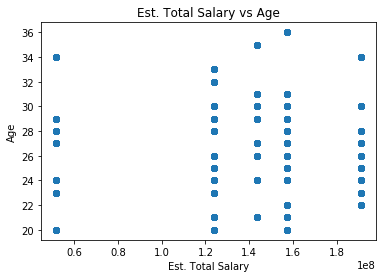

In [89]:
# Scatter plot
plt.scatter(epl_soccer['est_total_salary'],epl_soccer['age'])
plt.title('Est. Total Salary vs Age')
plt.xlabel("Est. Total Salary")
plt.ylabel("Age")
plt.show()

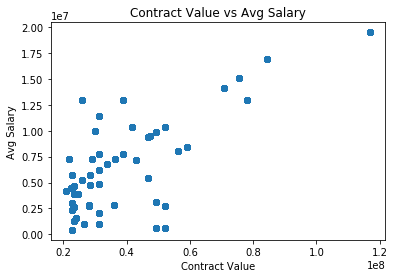

In [90]:
# Scatter plot
plt.scatter(epl_soccer['contract_value'],epl_soccer['avg_salary'])
plt.title('Contract Value vs Avg Salary')
plt.xlabel("Contract Value")
plt.ylabel("Avg Salary")
plt.show()

### Visual 2

In [91]:
# Filter down to only Arsenal records
arsenal_players = epl_soccer[epl_soccer['team_name'] == 'Arsenal']
arsenal_players.shape

(830, 85)

In [92]:
# Filter down to only Manchester United records
manu_players = epl_soccer[epl_soccer['team_name'] == 'Manchester United']
manu_players.shape

(808, 85)

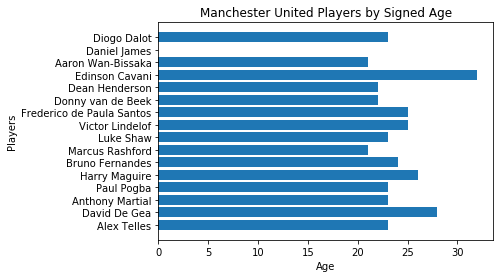

In [93]:
# Look at Manchester United Players by Signed Age
plt.barh(manu_players['players'], manu_players['signed_age'])
plt.title('Manchester United Players by Signed Age')
plt.xlabel("Age")
plt.ylabel("Players")
plt.show()

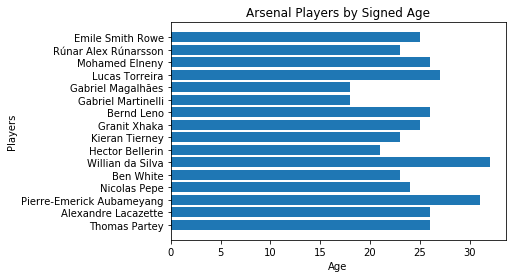

In [94]:
# Look at Arsenal Players by Signed Age
plt.barh(arsenal_players['players'], arsenal_players['signed_age'])
plt.title('Arsenal Players by Signed Age')
plt.xlabel("Age")
plt.ylabel("Players")
plt.show()

### Visual 3

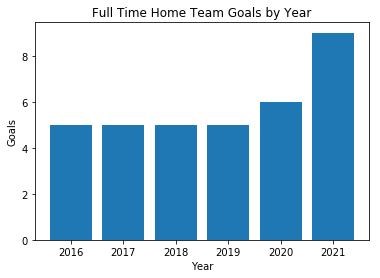

In [95]:
# Bar chart
plt.bar(epl_soccer['year'], epl_soccer['FTHG'])
plt.title('Full Time Home Team Goals by Year')
plt.xlabel("Year")
plt.ylabel("Goals")
plt.show()

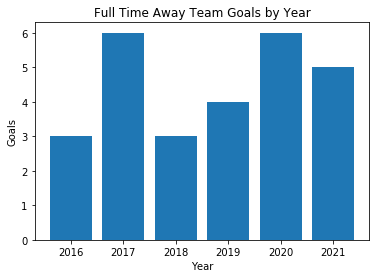

In [96]:
# Bar chart
plt.bar(epl_soccer['year'], epl_soccer['FTAG'])
plt.title('Full Time Away Team Goals by Year')
plt.xlabel("Year")
plt.ylabel("Goals")
plt.show()

### Visual 4

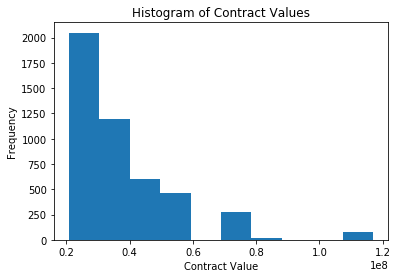

In [97]:
# Histogram
plt.hist(epl_soccer['contract_value'], bins=10)
plt.title('Histogram of Contract Values')
plt.xlabel("Contract Value")
plt.ylabel("Frequency")
plt.show()

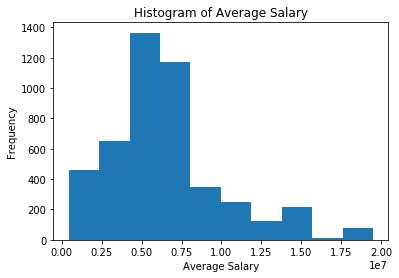

In [98]:
# Histogram
plt.hist(epl_soccer['avg_salary'], bins=10)
plt.title('Histogram of Average Salary')
plt.xlabel("Average Salary")
plt.ylabel("Frequency")
plt.show()

### Visual 5

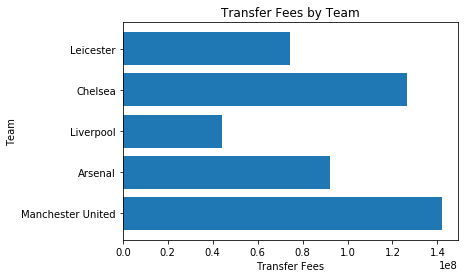

In [99]:
# Bar plot
plt.barh(epl_soccer['team_name'], epl_soccer['team_transfer_fees'])
plt.title('Transfer Fees by Team')
plt.xlabel("Transfer Fees")
plt.ylabel("Team")
plt.show()